# 1. Giriş
Bu projede, UCI Adult Census Income veri seti kullanılarak bireylerin yıllık gelirinin 50K'nın üzerinde olup olmadığı sınıflandırılacaktır.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


## 2. Veri Setinin Yüklenmesi ve İlk İnceleme

Bu bölümde, Kaggle'dan eklediğimiz **Adult Census Income** veri setini yüklüyoruz ve temel özelliklerini inceleyerek veriyle tanışıyoruz.


In [2]:
df = pd.read_csv('/kaggle/input/adult-census-income/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
print(f"Veri sayısı: {df.shape[0]}")
print("\nEksik değer sayısı:")
print(df.isnull().sum())

Veri sayısı: 32561

Eksik değer sayısı:
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [4]:
df = df.replace('?', np.nan)
df = df.dropna()


In [5]:
print(f"\n veri sayısı: {df.shape[0]}")



 veri sayısı: 30162


In [6]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


# 3. Keşifsel Veri Analizi (EDA)

Bu adımda, veri setindeki hedef değişkenin (`income`) dağılımına, sayısal değişkenlerin istatistiksel yapısına ve bazı kategorik değişkenlerin hedef değişkenle ilişkisine görselleştirme yardımıyla bakacağız.

In [7]:
df_eda = df.copy()


bins = [0, 25, 35, 45, 55, 65, 100]
labels = ['0–25', '26–35', '36–45', '46–55', '56–65', '65+']
df_eda['age_group'] = pd.cut(df_eda['age'], bins=bins, labels=labels)

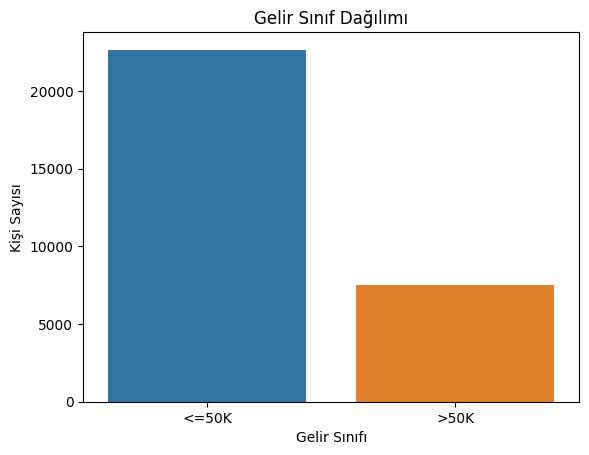

In [8]:
sns.countplot(x="income", data=df_eda)
plt.title("Gelir Sınıf Dağılımı")
plt.xlabel("Gelir Sınıfı")
plt.ylabel("Kişi Sayısı")
plt.show()


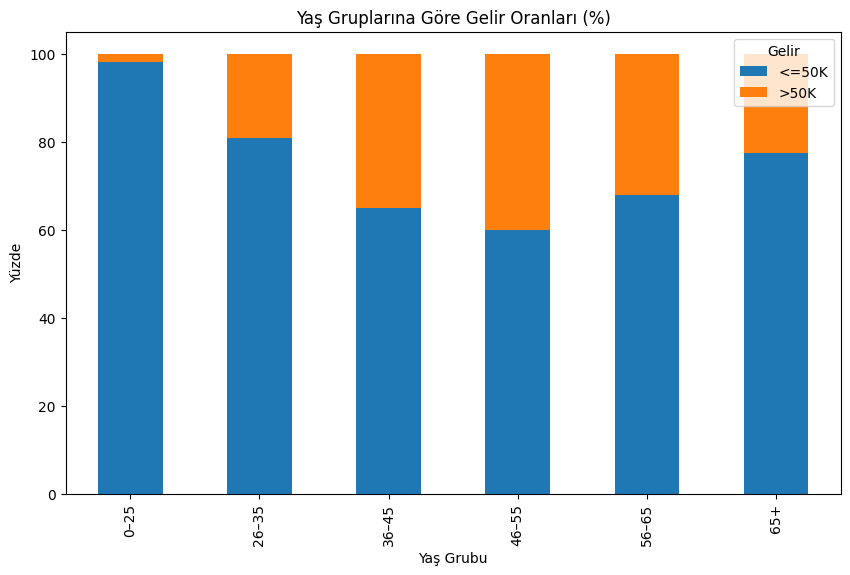

In [9]:
age_income_ratio = pd.crosstab(df_eda['age_group'], df_eda['income'], normalize='index') * 100
age_income_ratio.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Yaş Gruplarına Göre Gelir Oranları (%)")
plt.ylabel("Yüzde")
plt.xlabel("Yaş Grubu")
plt.legend(title="Gelir")
plt.show()


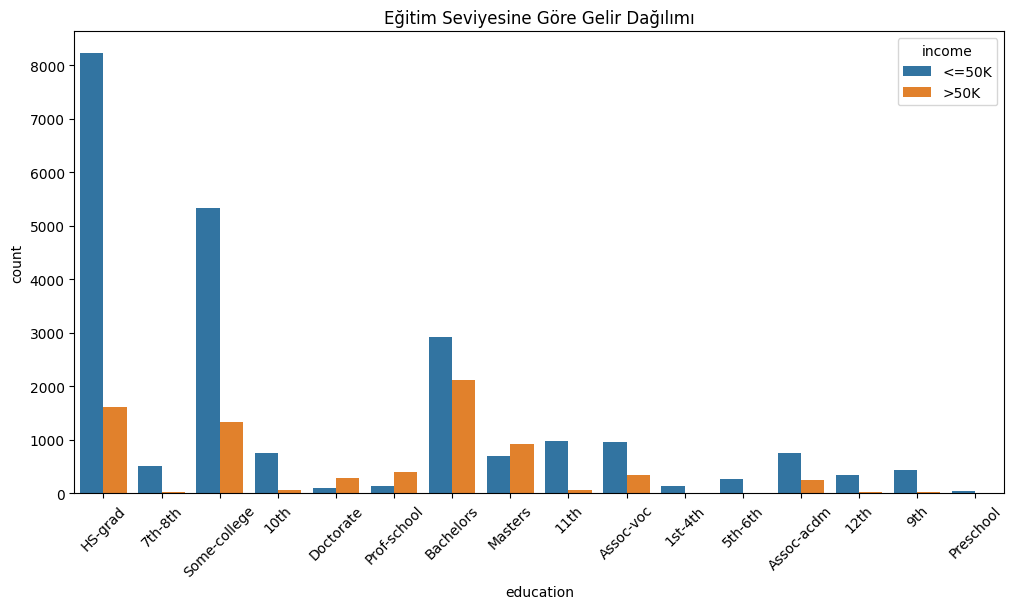

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x="education", hue="income", data=df_eda)
plt.xticks(rotation=45)
plt.title("Eğitim Seviyesine Göre Gelir Dağılımı")
plt.show()


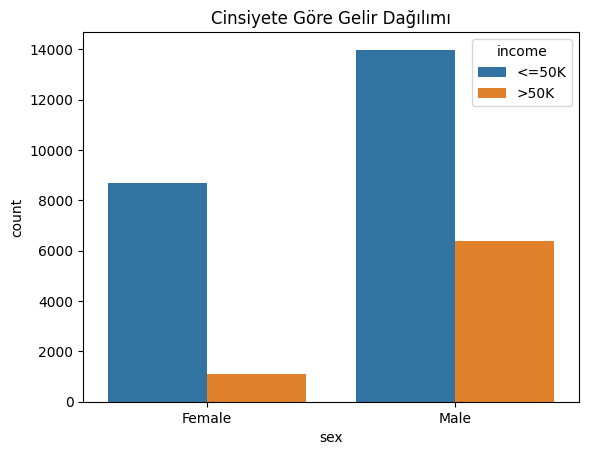

In [11]:
sns.countplot(x="sex", hue="income", data=df_eda)
plt.title("Cinsiyete Göre Gelir Dağılımı")
plt.show()


## 4. Veri Ön İşleme

Model eğitimi için veri setini uygun forma getirmemiz gerekiyor. Bu adımda:
Kategorik verileri sayısal formata çeviriyoruz.
Veri setini eğitim ve test kümelerine ayırıyoruz.


In [12]:
df_model = df.copy() 


In [13]:
le = LabelEncoder()

for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = le.fit_transform(df_model[col])


In [14]:
X = df_model.drop('income', axis=1)
y = df_model['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim  boyutu: {X_train.shape}")
print(f"Test  boyutu: {X_test.shape}")


Eğitim  boyutu: (24129, 14)
Test  boyutu: (6033, 14)


In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## 5.Model Seçimi Eğitimi 

Bu adımda, proje şartlarına uygun olarak birkaç farklı sınıflandırma algoritması uygulanacaktır.

Amaç, veri kümesi üzerinde en iyi sonuç veren modeli belirlemek


In [16]:
#LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4533
           1       0.72      0.44      0.55      1500

    accuracy                           0.82      6033
   macro avg       0.78      0.69      0.72      6033
weighted avg       0.81      0.82      0.80      6033

[[4274  259]
 [ 840  660]]


In [17]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("Decision Tree")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))


Decision Tree
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4533
           1       0.60      0.62      0.61      1500

    accuracy                           0.80      6033
   macro avg       0.74      0.74      0.74      6033
weighted avg       0.81      0.80      0.80      6033

[[3915  618]
 [ 571  929]]


In [18]:
#RANDOM FOREST
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))



Random Forest
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4533
           1       0.73      0.62      0.67      1500

    accuracy                           0.85      6033
   macro avg       0.81      0.77      0.79      6033
weighted avg       0.84      0.85      0.84      6033

[[4190  343]
 [ 567  933]]


In [19]:
#XGBOOST
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4533
           1       0.76      0.65      0.70      1500

    accuracy                           0.86      6033
   macro avg       0.82      0.79      0.80      6033
weighted avg       0.86      0.86      0.86      6033

[[4217  316]
 [ 522  978]]


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": y_pred_lr,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

print(" Model Karşılaştırmaları")
for name, y_pred in models.items():
    print(f"\n{name}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")


 Model Karşılaştırmaları

Logistic Regression
Accuracy:  0.8178
Precision: 0.7182
Recall:    0.4400
F1 Score:  0.5457

Decision Tree
Accuracy:  0.8029
Precision: 0.6005
Recall:    0.6193
F1 Score:  0.6098

Random Forest
Accuracy:  0.8492
Precision: 0.7312
Recall:    0.6220
F1 Score:  0.6722

XGBoost
Accuracy:  0.8611
Precision: 0.7558
Recall:    0.6520
F1 Score:  0.7001


In [21]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


param_grid = {
    'n_estimators': [100],     
    'max_depth': [3, 5],        
    'learning_rate': [0.1]    
}


grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=1  # Kaggle'da daha kararlı
)


grid_search.fit(X_train, y_train)


xgb_best_model = grid_search.best_estimator_


print("parametreler:", grid_search.best_params_)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


Accuracy : 0.8669
Precision: 0.7813
Recall   : 0.6453
F1 Score : 0.7068


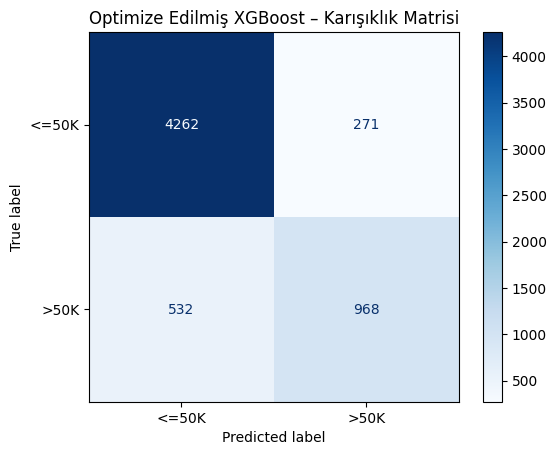

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


y_pred_final = xgb_best_model.predict(X_test)



print(f"Accuracy : {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_final):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_final):.4f}")


cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Optimize Edilmiş XGBoost – Karışıklık Matrisi")
plt.show()